In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd


In [3]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

def get_emotion_from_filename(filename):
    # Filename pattern: '03-01-04-02-02-02-12.wav'
    parts = filename.split("-")
    emotion_id = parts[2]
    return emotion_map.get(emotion_id)


In [4]:
def extract_features(file_path, duration=3, sr=22050):
    try:
        # Load audio with consistent sample rate
        y, sr = librosa.load(file_path, sr=sr)

        # Fix length: pad or clip to exactly 'duration' seconds
        desired_length = duration * sr
        if len(y) < desired_length:
            y = np.pad(y, (0, desired_length - len(y)))
        else:
            y = y[:desired_length]

        # Start feature list
        features = []

        # MFCC (40)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        features.extend(np.mean(mfcc, axis=1))

        # Chroma (12)
        stft = np.abs(librosa.stft(y))
        chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
        features.extend(np.mean(chroma, axis=1))

        # Mel Spectrogram (128)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        features.extend(np.mean(mel, axis=1))

        # Spectral Contrast (7)
        contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
        features.extend(np.mean(contrast, axis=1))

        # Tonnetz (6)
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
        features.extend(np.mean(tonnetz, axis=1))

        # Sanity check (should be 193 features)
        if len(features) != 193:
            print(f"⚠️ Feature shape mismatch for {file_path}: Got {len(features)}")
            return None

        return np.array(features)

    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None

In [5]:
data_path = '/content/drive/MyDrive/Audio_dataset'  # change if needed

X, y = [], []

parent_folders = ['Audio_Speech_Actors_01-24', 'Audio_Song_Actors_01-24']

for parent in parent_folders:
    parent_path = os.path.join(data_path, parent)
    for actor_folder in os.listdir(parent_path):
        actor_path = os.path.join(parent_path, actor_folder)
        if not os.path.isdir(actor_path):
            continue
        for file in os.listdir(actor_path):
            if file.endswith('.wav'):
                full_path = os.path.join(actor_path, file)
                emotion = get_emotion_from_filename(file)
                features = extract_features(full_path)
                if features is not None and emotion is not None:
                    X.append(features)
                    y.append(emotion)



In [6]:
print("✅ Total files loaded:", len(X))
print("✅ Feature shape (example):", X[0].shape if X else 'None')
print("✅ Unique emotions:", set(y))

✅ Total files loaded: 2452
✅ Feature shape (example): (193,)
✅ Unique emotions: {'angry', 'disgust', 'surprised', 'sad', 'neutral', 'calm', 'fearful', 'happy'}


In [7]:
X = np.array(X)
y = np.array(y)

print("✅ Feature shape:", X.shape)
print("✅ Label shape:", y.shape)

✅ Feature shape: (2452, 193)
✅ Label shape: (2452,)


In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_onehot = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("✅ Train shape:", X_train.shape)
print("✅ Test shape:", X_test.shape)

✅ Train shape: (1961, 193)
✅ Test shape: (491, 193)


In [9]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [84]:

pca = PCA(n_components=X_train.shape[1], svd_solver='full')
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("✅ Final feature shape after PCA:", X_train_pca.shape)

✅ Final feature shape after PCA: (1961, 193)


In [91]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2,l1_l2
from tensorflow.keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.5,
    verbose=1
)

loss_fn = SparseCategoricalCrossentropy()

model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_pca.shape[1],), kernel_regularizer=l1_l2(l1=0.0001,l2=0.0001)),
    BatchNormalization(),  # Optional, uncomment to try
    Dropout(0.4),

    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0001,l2=0.0001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0001,l2=0.0001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(8, activation='softmax')  # 8 emotion classes
])

model.compile(loss=loss_fn, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(X_train_pca, y_train, validation_data=[X_test_pca,y_test], epochs=120,batch_size=32,verbose=1)


Epoch 1/120


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.1654 - loss: 3.3559 - val_accuracy: 0.2077 - val_loss: 2.6362
Epoch 2/120
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3110 - loss: 2.6084 - val_accuracy: 0.2485 - val_loss: 2.5672
Epoch 3/120
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3588 - loss: 2.3488 - val_accuracy: 0.3116 - val_loss: 2.4549
Epoch 4/120
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4757 - loss: 2.0637 - val_accuracy: 0.3442 - val_loss: 2.3331
Epoch 5/120
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4861 - loss: 1.9972 - val_accuracy: 0.3931 - val_loss: 2.1785
Epoch 6/120
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5261 - loss: 1.9221 - val_accuracy: 0.4725 - val_loss: 2.0006
Epoch 7/120
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5435 - loss: 1.8205 - val_accuracy: 0.5560 - val_loss: 1.8339
Epoch 8/120
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5460 - loss: 1.7917 - val_accuracy: 0.6069 - val_loss: 1.

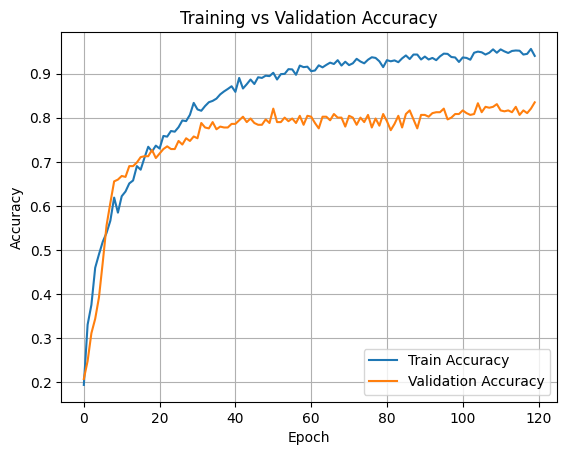

In [92]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [93]:
# If you already called .predict earlier:
y_pred_proba = model.predict(X_test_pca)

# Now check if it's 2D
print(y_pred_proba.shape)  # Should be (num_samples, num_classes)

# Convert softmax probabilities → class labels
y_pred = np.argmax(y_pred_proba, axis=1)
print(classification_report(y_test, y_pred, target_names=le.classes_))
print(f"✅ Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(491, 8)
              precision    recall  f1-score   support

       angry       0.82      0.92      0.87        75
        calm       0.89      0.91      0.90        75
     disgust       0.86      0.77      0.81        39
     fearful       0.78      0.79      0.78        75
       happy       0.87      0.80      0.83        75
     neutral       0.81      0.79      0.80        38
         sad       0.79      0.83      0.81        75
   surprised       0.89      0.82      0.85        39

    accuracy                           0.84       491
   macro avg       0.84      0.83      0.83       491
weighted avg       0.84      0.84      0.83       491

✅ Test Accuracy: 0.8350


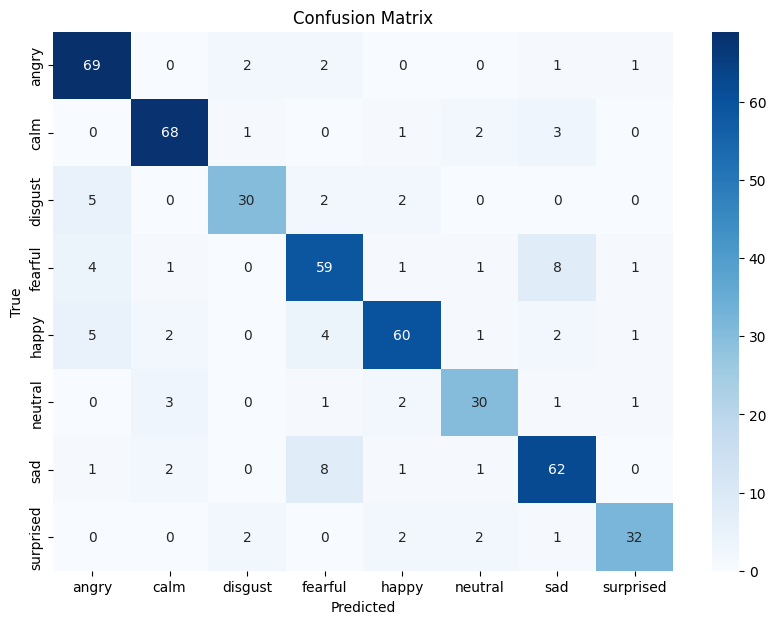

In [94]:

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [101]:
model.save('/content/drive/MyDrive/SER.keras')

In [98]:
!cp /content/SER.keras/content/drive/MyDrive/

cp: missing destination file operand after '/content/SER.keras/content/drive/MyDrive/'
Try 'cp --help' for more information.
